## Sistema de Recomendação de Filmes da Netflix

o objetivo da Net Flix é fazer com que as pessoas assistam aos filmes que mais gostam, sendo assim utiliza um sistema de 
recomendação, com sugestões de filmes com maior chance de estarem certas 

Os dados utilizados estão nese endereço https://www.kaggle.com/netflix-inc/netflix-prize-data

In [1]:
# Imports
import os # para manipulação do Sistema operacional
import random # para geração de valores randomicos
import numpy as np # para gerar as matrizes
import pandas as pd # para gerar o dataframe
import seaborn as sns # gerar gráficos
import matplotlib # gerar gráficos
%matplotlib inline
import matplotlib.pyplot as plt # gerar gráficos                 
import scipy # operações mais avançadas com as matrizes
import sklearn # para construção do modelo de machine learning
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime # para medir o tempo de algumas operações



# Formatação dos gráficos
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "NetFlix Prize Data " --iversions

pandas     1.1.5
sklearn    0.23.2
scipy      1.5.2
numpy      1.19.2
seaborn    0.11.0
matplotlib 3.3.2
NetFlix Prize Data


### Carregar os dados

Para carregar os dados vamos executar as seguintes operações:

- 1- Fazer a leitura das linhas de todos os arquivos disponíveis.
- 2- Combinar todas as linhas de todos os arquivos em um único arquivo.
- 3- Carregar o arquivo gerado em um dataframe do pandas.

In [3]:
# Marca o início da execução de leitura dos arquivos.
start = datetime.now()

In [4]:
# Criaremos um arquivo final chamado dados.csv

# Se o arquivo não existir, criamos o arquivo em modo de escrita (w)
if not os.path.isfile('dados/dados.csv'):
    
    # Cria e abre o arquivo para gravação
    dataset = open('dados/dados.csv', mode = 'w')
    
    # Lista para as linhas dos arquivos
    linhas = list()
    
    # Nomes e caminhos dos arquivos
    arquivos = ['dados/combined_data_1.txt',
                'dados/combined_data_2.txt', 
                'dados/combined_data_3.txt', 
                'dados/combined_data_4.txt']
    
    # Loop por cada arquivo na lista de arquivos
    for arquivo in arquivos:
        
        # Print
        print("Lendo o arquivo {}...".format(arquivo))
        
        # Com o arquivo aberto, extraímos as linhas
        with open(arquivo) as f:
            
            # Loop por cada linha do arquivo
            for linha in f: 
                
                # Deletamos o conteúdo da lista
                del linhas[:] 
                
                # Divide as linhas do arquivo pelo caracter de final de linha
                linha = linha.strip()
                
                # Se encontramos "dois pontos" ao final da linha, fazemos replace removendo o caracter,
                # pois queremos apenas o id do filme
                if linha.endswith(':'):
                    movie_id = linha.replace(':', '')
                    
                # Se não, criamos uma lista comprehension para fazer a separação das colunas por vírgula
                else:
                    
                    # Separa as colunas
                    linhas = [x for x in linha.split(',')]
                    
                    # Usa o id do filme na posição de índice zero
                    linhas.insert(0, movie_id)
                    
                    # Grava o resultado no novo arquivo
                    dataset.write(','.join(linhas))
                    dataset.write('\n')
                    
        print("Concluído.\n")
        
    dataset.close()

In [5]:
# Imprime o tempop total
print('Tempo Total Para Carregar os Arquivos:', datetime.now() - start)

Tempo Total Para Carregar os Arquivos: 0:00:00.385790


In [6]:
print("Criando um dataframe a partir dos dados gerados acima no arquivo dados.csv...")
df_netflix = pd.read_csv('dados/dados.csv', sep =',', names =['movie','user','rating','date'])
df_netflix.date = pd.to_datetime(df_netflix.date)
print('concluído')

Criando um dataframe a partir dos dados gerados acima no arquivo dados.csv...
concluído


In [7]:
# Ordenando o dataframe por data
print('Ordenando o dataframe por data..')
df_netflix.sort_values(by = 'date', inplace = True)
print('Concluído.')

Ordenando o dataframe por data..
Concluído.


In [8]:
df_netflix.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [9]:
# shape
df_netflix.shape

(100480507, 4)

## Análise Exploratória dos Dados

In [10]:
# Resumo dos dados
print("Resumo dos Dados")
print("-"*50)
print("Número Total de Filmes:", len(np.unique(df_netflix.movie)))
print("Número Total de Usuários:", len(np.unique(df_netflix.user)))
print("Número Total de Avaliações:", df_netflix.shape[0])

Resumo dos Dados
--------------------------------------------------
Número Total de Filmes: 17770
Número Total de Usuários: 480189
Número Total de Avaliações: 100480507


In [11]:
# Vamos salvar esses dois valores para usar mais tarde
total_users = len(np.unique(df_netflix.user))
total_movies = len(np.unique(df_netflix.movie))

In [12]:
# Verificando a média das avaliações
df_netflix.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [13]:
# Verificando se temos valores ausentes
sum(df_netflix.isnull().any())

0

In [14]:
# Verificando se temos valores duplicados (para esse caso não consideramos a data)
sum(df_netflix.duplicated(['movie', 'user', 'rating']))

0

Vamos dividir os dados em treino e teste antes de continuar como a análise exploratória, pois algumas análises só fazem sentido para os dados de treino. Usaremos a proporção 80/20 para treino/teste.

In [15]:
# Criaremos um dataset em disco com os dados de treino
# Dessa forma não precisamos executar todo o processo de carga novamente cada vez que executar este notebook
if not os.path.isfile('dados/dados_treino.csv'):
    df_netflix.iloc[:int(df_netflix.shape[0] * 0.80)].to_csv("dados/dados_treino.csv", index = False)

In [16]:
# Criaremos um dataset em disco com os dados de teste
# Dessa forma não precisamos executar todo o processo de carga novamente cada vez que executar este notebook
if not os.path.isfile('dados/dados_teste.csv'):
    df_netflix.iloc[int(df_netflix.shape[0] * 0.80):].to_csv("dados/dados_teste.csv", index = False)

In [17]:
# Deletamos o dataframe original para liberar memória
del df_netflix

Quando executar este Jupyter Notebook novamente, pode iniciar a partir desta célula abaixo (após carregar os pacotes).

Caso tenha erro no Jupyter Noteboook, faça um refresh na aba com http://localhost:8888/tree.

In [18]:
# Agora carregamos os arquivos em dataframes do pandas
df_netflix_treino = pd.read_csv("dados/dados_treino.csv", parse_dates = ['date'])
df_netflix_teste = pd.read_csv("dados/dados_teste.csv")

In [19]:
# Resumo dos dados de treino
print("Resumo dos Dados de Treino")
print("-"*50)
print("Número Total de Filmes:", len(np.unique(df_netflix_treino.movie)))
print("Número Total de Usuários:", len(np.unique(df_netflix_treino.user)))
print("Número Total de Avaliações:", df_netflix_treino.shape[0])

Resumo dos Dados de Treino
--------------------------------------------------
Número Total de Filmes: 17424
Número Total de Usuários: 405041
Número Total de Avaliações: 80384405


In [20]:
# Resumo dos dados de teste
print("Resumo dos Dados de Teste")
print("-"*50)
print("Número Total de Filmes:", len(np.unique(df_netflix_teste.movie)))
print("Número Total de Usuários:", len(np.unique(df_netflix_teste.user)))
print("Número Total de Avaliações:", df_netflix_teste.shape[0])

Resumo dos Dados de Teste
--------------------------------------------------
Número Total de Filmes: 17757
Número Total de Usuários: 349312
Número Total de Avaliações: 20096102


A função abaixo vai ajustar as medidas em milhares, milhões e bilhões para facilitar a leitura dos gráficos.

In [21]:
# Função para ajuste das unidades de medida
def ajusta_unidades(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [22]:
# Supress warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

__Vamos verificar a distribuição das avaliações.__

<IPython.core.display.Javascript object>


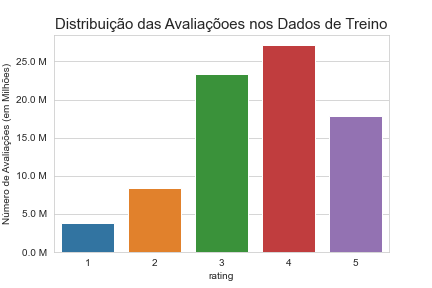

In [23]:
# Plot
fig, ax = plt.subplots()
plt.title('Distribuição das Avaliaçõoes nos Dados de Treino', fontsize = 15)
sns.countplot(df_netflix_treino.rating)
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Número de Avaliações (em Milhões)')
plt.show()

Vamos ver por dia da semana se tem diferença na avaliação

In [24]:
# Parâmetro para evitar warning devido ao alto volume de dados
pd.options.mode.chained_assignment = None  

In [25]:
# Extrai o dia da semana e grava em uma nova coluna
df_netflix_treino['dia_semana'] = df_netflix_treino['date'].dt.strftime("%A")
df_netflix_treino.head()

,movie,user,rating,date,dia_semana
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


<IPython.core.display.Javascript object>


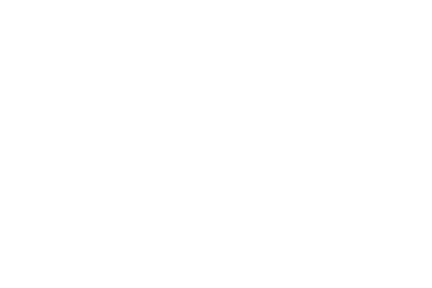

In [26]:
# Plot
fig, ax = plt.subplots()
sns.countplot(x = 'dia_semana', data = df_netflix_treino, ax = ax)
plt.title('Número de Avaliações Por Dia da Semana')
plt.ylabel('Total de Avaliações')
plt.xlabel('')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

Agora vamos calcular a média de avaliações por dia da semana 

In [27]:

media_da_semana = df_netflix_treino.groupby(by = ['dia_semana'])['rating'].mean()
print("Média da semana")
print("-"*30)
print(media_da_semana)
print("\n")

Média da semana
------------------------------
dia_semana
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




Nao parece ter influência das avalições o dia da semana

Vamos analizar ao longo do tempo

<IPython.core.display.Javascript object>


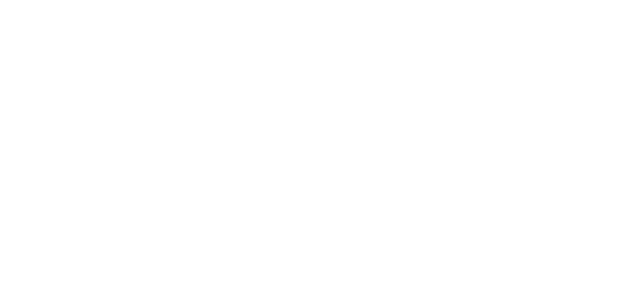

In [28]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax = df_netflix_treino.resample('m', on = 'date')['rating'].count().plot()
ax.set_title('Número de Avaliações Por Mês nos Dados de Treino')
plt.xlabel('Mês')
plt.ylabel('Número de Avaliações Por Mês)')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

In [29]:
num_val_por_user = df_netflix_treino.groupby(by = 'user')['rating'].count().sort_values(ascending = False)
num_val_por_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64